In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, io
from ase.build import molecule, make_supercell
from ase.quaternions import Quaternion
from muspinsim.spinsys import SpinSystem, MuonSpinSystem
from muspinsim.spinop import DensityOperator
from muspinsim.experiment import MuonExperiment
from muspinsim.constants import MU_GAMMA
from soprano.selection import AtomSelection
from soprano.properties.linkage import Molecules
from soprano.properties.transform import Rotate
from soprano.nmr.utils import _dip_constant, _dip_tensor
from soprano.calculate.powder import ZCW, SHREWD
from soprano.calculate.dipolar.randsums import _scalar_sum_distribution
from soprano.data.nmr import (_get_isotope_data, _get_nmr_data, _el_iso)
from soprano.utils import periodic_bridson, minimum_periodic, minimum_supcell, supcell_gridgen
from soprano.properties.nmr.dipolar import DipolarRSS, DipolarTensor, DipolarCoupling
from scipy.interpolate import interp1d

In [3]:
# The model system will be a octahedral hydrogen cluster

pos = np.array(np.meshgrid(*[[-1,0,1]]*3)).reshape((3,-1)).T
pos = pos[np.where(np.linalg.norm(pos, axis=1) == 1)]*0.5

a = Atoms('H'*len(pos), positions=pos, cell=np.eye(3)*10)
# rot = Rotate(quaternion=Quaternion.from_axis_angle([0,1,0.5], 1.3))
# a = rot(a)
assert(len(Molecules.get(a)) == 1)
io.write('clusterH.cif', a)

In [10]:
class VanVleck(object):
    
    def __init__(self, atoms):
        self.atoms = atoms
        self.Dc = DipolarCoupling.get(atoms)
        self.D = DipolarTensor.get(atoms)
        for k, D in self.D.items():
            self.Dc[k] = self.Dc[k][0]*1e-3
            self.D[k] = D*1e-3
        
        # Calculate all Bjks
        self.Bvals = [[0 if i == j else self.Bjk(i,j) for j in range(len(atoms))] for i in range(len(atoms))]
        self.Bvals = np.array(self.Bvals)
        
        self.I = _get_isotope_data(self.atoms.get_chemical_symbols(), 'I')
    
    # Here following the nomenclature from Van Vleck's paper    
    def Bjk(self, j, k, axis=[0,0,1]):
        axis = np.array(axis).astype(float)
        axis /= np.linalg.norm(axis)
        aa = axis[:,None]*axis[None,:]
        jk = tuple(sorted([j, k]))
        D = self.D[jk]
        return -1.5*np.sum(aa*D)
    
    def std2_single(self, axis=[0,0,1]):
        I = self.I
        B = [[0 if i == j else self.Bjk(i,j, axis) for j in range(len(I))] for i in range(len(I))]
        B = np.array(B)
        return np.sum(I[:,None]*(I[None,:]+1.0)*B**2/3.0)/len(I)
    
    def std2_powder(self):
        I = self.I
        B = [[0 if i == j else 1.5*self.Dc[tuple(sorted((i,j)))] for j in range(len(I))] for i in range(len(I))]
        B = np.array(B)
        return np.sum(I[:,None]*(I[None,:]+1.0)*B**2*(4.0/15.0))/len(I)
    
    def dipfreqs(self, B=[0,0,1]):
        
        B = np.array(B)
        atoms = self.atoms
        ssys = SpinSystem(atoms.get_chemical_symbols())
        
        for i in range(len(atoms)):
            ssys.add_linear_term(i, B*ssys.gamma(i)*1e3)
            for j in range(i+1, len(ssys)):
                ssys.add_bilinear_term(i, j, self.D[(i,j)])
                
        H = ssys.hamiltonian
        Sxtot = sum([ssys.operator({i: 'x'}) for i in range(len(ssys))], 0*ssys.operator({}))
        evals, evecs = H.diag()
        Sxdiag = Sxtot.basis_change(evecs)

        freqs = (evals[:,None]-evals[None,:]).reshape((-1,))
        weights = np.abs(Sxdiag.matrix.T.reshape((-1,)))

        # Central frequency?
        larmor = np.linalg.norm(B)*ssys.gamma(0)*1e3
        # Which ones are close enough?
        peak_inds = np.where((abs(freqs-larmor) < 0.5*larmor)*(1-np.isclose(weights, 0)))
        
        return (freqs[peak_inds]-larmor), weights[peak_inds]

In [11]:
vvleck = VanVleck(a)
freqs, weights = vvleck.dipfreqs()
sigma = (vvleck.std2_single()**0.5)
sigmafreq = (np.sum(weights**2*freqs**2)/np.sum(weights**2))**0.5

print(sigma)
print(sigmafreq)

[412.84461524 412.84461524 312.08119486 312.08119486 412.84461524
 412.84461524]
382.21984286794725
382.2925175873221


In [22]:
pwd = ZCW('sphere')
orients, weights = pwd.get_orient_points(100)

sigmapwd = vvleck.std2_powder()**0.5
sigmaorient = np.average([vvleck.std2_single(p) for p in orients], weights=weights)**0.5

print(sigmapwd)
print(sigmaorient)

[[   0.         -509.62645716 -509.62645716 -509.62645716 -509.62645716
  -180.18016186]
 [-509.62645716    0.         -509.62645716 -509.62645716 -180.18016186
  -509.62645716]
 [-509.62645716 -509.62645716    0.         -180.18016186 -509.62645716
  -509.62645716]
 [-509.62645716 -509.62645716 -180.18016186    0.         -509.62645716
  -509.62645716]
 [-509.62645716 -180.18016186 -509.62645716 -509.62645716    0.
  -509.62645716]
 [-180.18016186 -509.62645716 -509.62645716 -509.62645716 -509.62645716
     0.        ]]
462.89121704089115
462.8793801792501


In [16]:
# Classic field distribution
all_specs = []
conv_s = 10
for i in range(len(a)):
    scalars = []
    for j in range(len(a)):
        if i == j:
            continue
        B = vvleck.Bjk(i,j)/1.5
        scalars.append([(B, -B), (0.5, 0.5)])
    om, P = _scalar_sum_distribution(scalars, 501)
    P = np.convolve(P, np.exp(-om**2/(2*conv_s**2)), mode='same')
    P /= np.trapz(P, om)
    spec = interp1d(om, P, bounds_error=False, fill_value=(0,0))
    all_specs.append(spec)

<IPython.core.display.Javascript object>


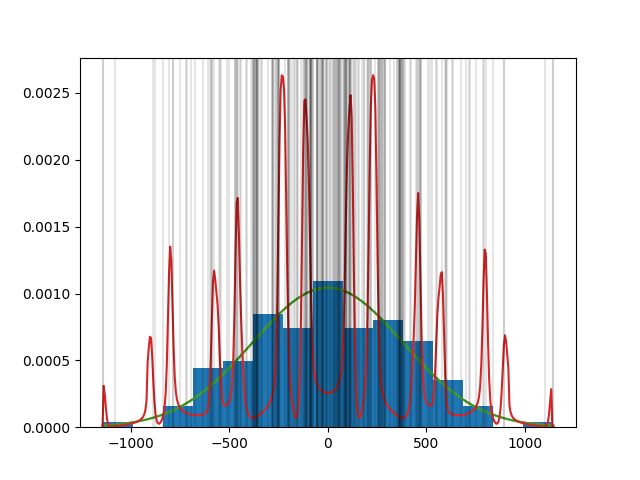

In [17]:
fig, ax = plt.subplots()

ax.hist(freqs, weights=weights, bins=15, density=True)

faxis = np.linspace(np.amin(freqs), np.amax(freqs), 401)

ax.plot(faxis, np.exp(-faxis**2/(2*sigma**2))/(2*np.pi*sigma**2)**0.5)    
ax.plot(faxis, np.exp(-faxis**2/(2*sigmafreq**2))/(2*np.pi*sigmafreq**2)**0.5)

classicP = np.average([s(faxis) for s in all_specs], axis=0)
ax.plot(faxis, classicP)

for f in freqs:
    ax.axvline(f, c=(0,0,0,0.1))

In [9]:
# Powder version?

pwd = ZCW('sphere')
orients, weights = pwd.get_orient_points(100)

sigmapwd = vvleck.std2_powder()**0.5
sigmaorient = np.average([vvleck.std2_single(p) for p in orients], weights=weights)**0.5
orientfreqs = np.array([])
orientweights = np.array([])

for o, w in zip(orients, weights):
    ofreqs, oweights = vvleck.dipfreqs(5.0*o)
    orientfreqs = np.concatenate([orientfreqs, ofreqs])
    orientweights = np.concatenate([orientweights, oweights*w])


sigmaorientfreq = (np.sum(orientweights**2*orientfreqs**2)/np.sum(orientweights**2))**0.5

print(sigmapwd)
print(sigmaorient)
print(sigmaorientfreq)

462.89121704089115
462.8793801792501
462.8604972305358


In [10]:
# Classic field distribution
all_specs_pwd = []
conv_s = 0.1
for o, w in zip(orients, weights):
    for i in range(len(a)):
        scalars = []
        for j in range(len(a)):
            if i == j:
                continue
            B = vvleck.Bjk(i,j, o)/1.5
            scalars.append([(B, -B), (0.5, 0.5)])
        om, P = _scalar_sum_distribution(scalars, 100)
        P = np.convolve(P, np.exp(-om**2/(2*conv_s**2)), mode='same')
        P *= w/np.trapz(P, om)/len(a)
        spec = interp1d(om, P, bounds_error=False, fill_value=(0,0))
        all_specs_pwd.append(spec)

<IPython.core.display.Javascript object>


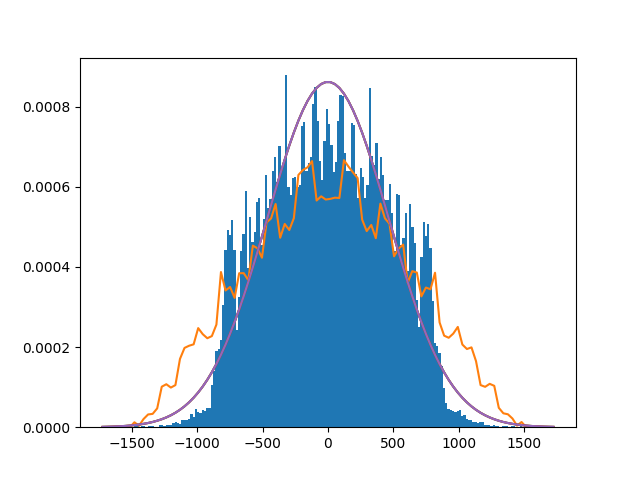

In [11]:
fig, ax = plt.subplots()

ax.hist(orientfreqs, weights=orientweights, bins=200, density=True)

faxis = np.linspace(np.amin(orientfreqs), np.amax(orientfreqs), 100)

classicPpwd = np.sum([s(faxis) for s in all_specs_pwd], axis=0)
ax.plot(faxis, classicPpwd)

ax.plot(faxis, np.exp(-faxis**2/(2*sigmapwd**2))/(2*np.pi*sigmapwd**2)**0.5)    
ax.plot(faxis, np.exp(-faxis**2/(2*sigmaorient**2))/(2*np.pi*sigmaorient**2)**0.5)
ax.plot(faxis, np.exp(-faxis**2/(2*sigmaorientfreq**2))/(2*np.pi*sigmaorientfreq**2)**0.5)